# SHAP-IQ with scikit-learn

In this example, we use the popular California housing dataset for regression available at https://www.kaggle.com/datasets/camnugent/california-housing-prices.

### Import Packages

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import shapiq

shapiq.__version__

'1.2.2'

### Load Data
Let's load the California housing dataset and split it into training and test sets.

In [2]:
X, y = shapiq.load_california_housing()
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.25, random_state=42
)
n_features = X_train.shape[1]

### Train a Model with Scikit-learn
Here we train a random forest regressor with 500 trees.
The model achieves a relatively high R2 score on the test set.

In [3]:
model = RandomForestRegressor(
    n_estimators=500, max_depth=n_features, max_features=2 / 3, max_samples=2 / 3, random_state=42
)
model.fit(X_train, y_train)
print("Train R2: {:.4f}".format(model.score(X_train, y_train)))
print("Test  R2: {:.4f}".format(model.score(X_test, y_test)))

Train R2: 0.7990
Test  R2: 0.7462


### Model-Agnostic Explainer

We use `shapiq.TabularExplainer` to explain any machine learning model for tabular data. 

It has the following basic parameters:

- `model`: The model to be explained as a callable function expecting data points as input and returning 1-dimensional predictions.

- `data`: A background dataset to be used for imputation.

In [4]:
explainer_tabular = shapiq.TabularExplainer(model=model, data=X_train, index="SII", max_order=2)

Next, select an instance to be explained.

In [5]:
x = X_test[24]

Call an `explain()` interface setting the `budget`, i.e. the maximum number of model evaluations (coallitions).

In [6]:
interaction_values = explainer_tabular.explain(x, budget=2**n_features, random_state=0)
interaction_values

InteractionValues(
    index=SII, max_order=2, min_order=0, estimated=False, estimation_budget=256,
    n_players=8, baseline_value=2.069974614065219
)

An output is stored in the `shapiq.InteractionValues` object. Its main attribute is `dict_values` storing Shapley interaction values as a dictionary.

In [7]:
interaction_values.dict_values

{(): 2.069974614065219,
 (0,): 0.051043759408163684,
 (1,): -0.08058465327223058,
 (2,): -0.0315185861263409,
 (3,): 0.0023698338795038083,
 (4,): 0.007482084448451898,
 (5,): -0.14868434078039494,
 (6,): 0.16848800648965162,
 (7,): -0.276187533350413,
 (0, 1): -0.032957450009117074,
 (0, 2): 0.011932155630669095,
 (0, 3): -0.007730641212960359,
 (0, 4): -0.006656005966161032,
 (0, 5): -0.07618110369549065,
 (0, 6): -0.052084702786043456,
 (0, 7): 0.033535226857198064,
 (1, 2): 0.00047292754985365614,
 (1, 3): 0.00011327714131894376,
 (1, 4): -0.0016523312115048895,
 (1, 5): 0.110440763256487,
 (1, 6): -0.0024114724623800817,
 (1, 7): 0.00042008190149422773,
 (2, 3): -0.004287785745259603,
 (2, 4): -0.0023031160877497133,
 (2, 5): -0.0023243607199934084,
 (2, 6): 0.006050252904892086,
 (2, 7): -0.008010678949884149,
 (3, 4): -0.001457783302027363,
 (3, 5): 0.0017843906932829725,
 (3, 6): -0.0027810795955241292,
 (3, 7): -0.0005917376126915988,
 (4, 5): -0.006850412464675745,
 (4, 6): -

One can retrieve only 2-order values with `get_n_order(2)` (object) and `get_n_order_values(2)` (values themselves).

In [8]:
interaction_values.get_n_order(2).dict_values

{(0, 1): -0.032957450009117074,
 (0, 2): 0.011932155630669095,
 (0, 3): -0.007730641212960359,
 (0, 4): -0.006656005966161032,
 (0, 5): -0.07618110369549065,
 (0, 6): -0.052084702786043456,
 (0, 7): 0.033535226857198064,
 (1, 2): 0.00047292754985365614,
 (1, 3): 0.00011327714131894376,
 (1, 4): -0.0016523312115048895,
 (1, 5): 0.110440763256487,
 (1, 6): -0.0024114724623800817,
 (1, 7): 0.00042008190149422773,
 (2, 3): -0.004287785745259603,
 (2, 4): -0.0023031160877497133,
 (2, 5): -0.0023243607199934084,
 (2, 6): 0.006050252904892086,
 (2, 7): -0.008010678949884149,
 (3, 4): -0.001457783302027363,
 (3, 5): 0.0017843906932829725,
 (3, 6): -0.0027810795955241292,
 (3, 7): -0.0005917376126915988,
 (4, 5): -0.006850412464675745,
 (4, 6): -0.0016677495497568276,
 (4, 7): -0.0006306331995297605,
 (5, 6): -0.015274832306927104,
 (5, 7): 0.024595880653738987,
 (6, 7): -0.06769283212926844}

In [9]:
interaction_values.get_n_order_values(2)

array([[ 5.10437594e-02, -3.29574500e-02,  1.19321556e-02,
        -7.73064121e-03, -6.65600597e-03, -7.61811037e-02,
        -5.20847028e-02,  3.35352269e-02],
       [-3.29574500e-02, -8.05846533e-02,  4.72927550e-04,
         1.13277141e-04, -1.65233121e-03,  1.10440763e-01,
        -2.41147246e-03,  4.20081901e-04],
       [ 1.19321556e-02,  4.72927550e-04, -3.15185861e-02,
        -4.28778575e-03, -2.30311609e-03, -2.32436072e-03,
         6.05025290e-03, -8.01067895e-03],
       [-7.73064121e-03,  1.13277141e-04, -4.28778575e-03,
         2.36983388e-03, -1.45778330e-03,  1.78439069e-03,
        -2.78107960e-03, -5.91737613e-04],
       [-6.65600597e-03, -1.65233121e-03, -2.30311609e-03,
        -1.45778330e-03,  7.48208445e-03, -6.85041246e-03,
        -1.66774955e-03, -6.30633200e-04],
       [-7.61811037e-02,  1.10440763e-01, -2.32436072e-03,
         1.78439069e-03, -6.85041246e-03, -1.48684341e-01,
        -1.52748323e-02,  2.45958807e-02],
       [-5.20847028e-02, -2.411472

### Visualization of Shapley interactions

`shapiq` includes the following plotting functions:

- [network_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.network_plot)

- [stacked_bar_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.stacked_bar_plot)

- [force_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.force_plot)

- and [bar_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.bar_plot) for global feature (interaction) importance.

For details of their parameters, refer to the [API reference](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html).

(<Figure size 600x600 with 1 Axes>, <Axes: >)

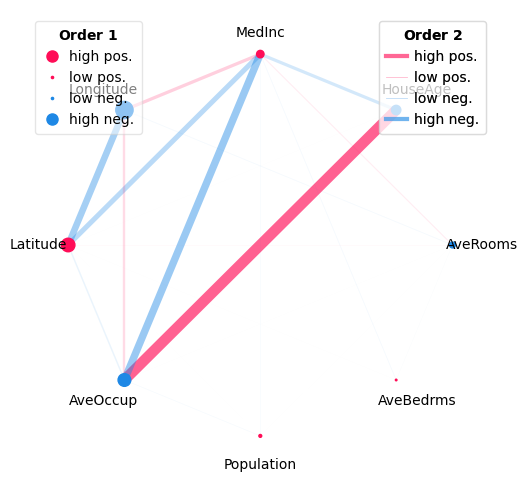

In [10]:
shapiq.network_plot(
    first_order_values=interaction_values.get_n_order_values(1),
    second_order_values=interaction_values.get_n_order_values(2),
    feature_names=X.columns,
)

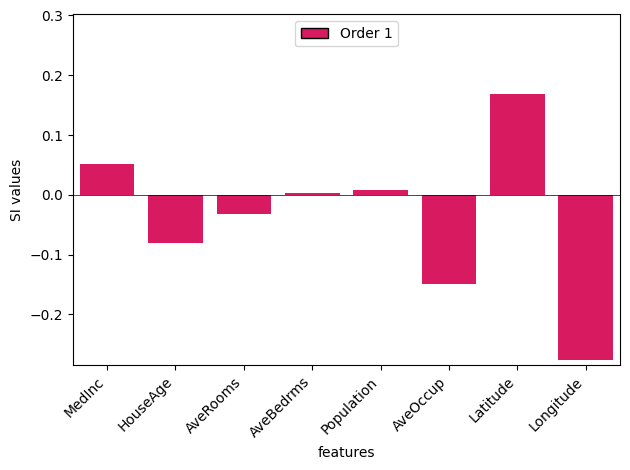

In [11]:
_ = shapiq.stacked_bar_plot(
    interaction_values.get_n_order(1),
    feature_names=X.columns,
)

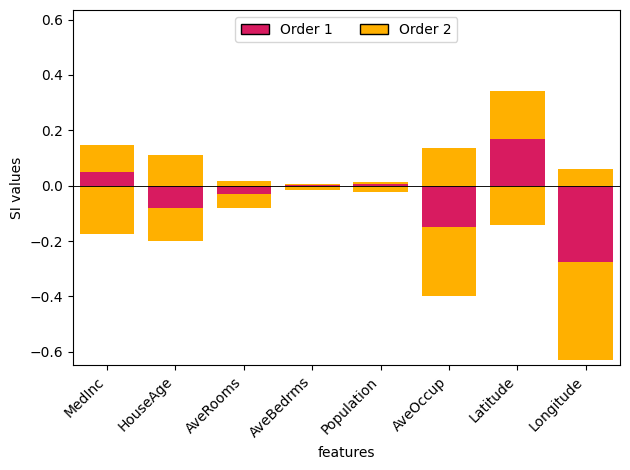

In [12]:
_ = shapiq.stacked_bar_plot(
    interaction_values=interaction_values,
    feature_names=X.columns,
)

After installing the `shap` Python package.

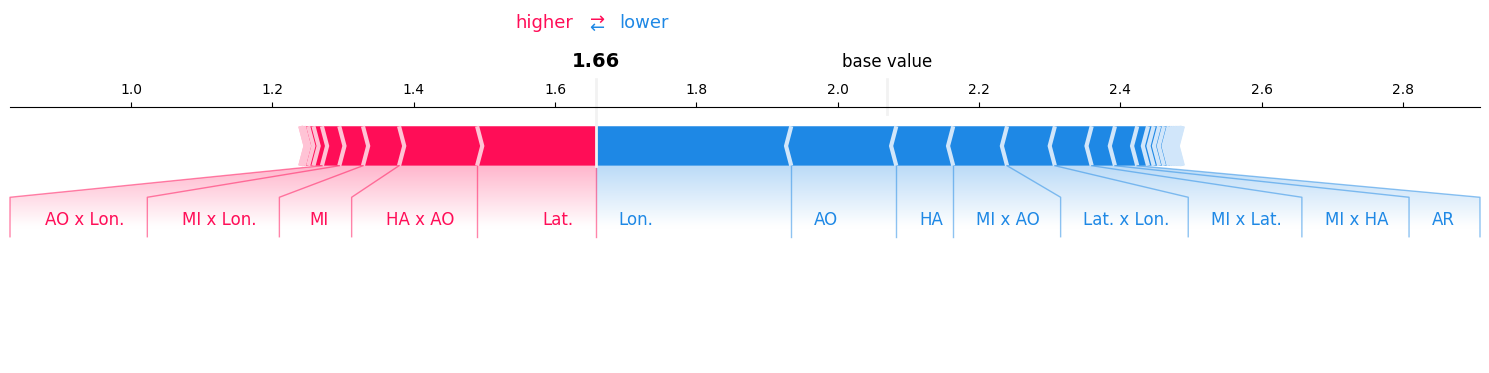

In [13]:
interaction_values.plot_force(feature_names=X.columns)